# Test model on various samples

In [15]:
import torch
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from random import randint
import numpy as np
import time
from scipy.stats import multivariate_normal
from math import floor, log2

from obb.model.oriented_reppoints_loss import OrientedRepPointsLoss

from obb.model.custom_model import *
from obb.utils.dataset import *
from obb.utils.polygon import *
from obb.utils.infer_ops import *
from obb.utils.box_ops import min_area_rect, gaussian_to_xywha, xywha_to_xyxy, rep_points_to_gaussian, xyxy_to_xywha

# set plot default values
plt.matplotlib.rc('grid', linestyle = 'dotted', linewidth=1.5, alpha = 0.25)
plt.matplotlib.rc('font', family='serif', size=11)
plt.matplotlib.rc('legend', fontsize=11)

# Change ticks
plt.rcParams['xtick.major.size'] = 7.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.major.size'] = 7.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['ytick.direction'] = 'inout'
colors = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#ad8966', ]

Epoch 1: 0.547861
Epoch 2: 0.404898
Epoch 3: 0.371566
Epoch 4: 0.351561
Epoch 5: 0.341587
Epoch 6: 0.333829
Epoch 7: 0.324830
Epoch 8: 0.315200
Epoch 9: 0.312631
Epoch 10: 0.305077
Epoch 11: 0.304155
Epoch 12: 0.298800
Epoch 13: 0.295684
Epoch 14: 0.293442
Epoch 15: 0.289303
Epoch 16: 0.255605
Epoch 17: 0.248106
Epoch 18: 0.244985
Epoch 19: 0.242726
Epoch 20: 0.240916
Epoch 21: 0.236916
Epoch 22: 0.235460
Epoch 23: 0.235030
Epoch 24: 0.238833
Epoch 25: 0.238050
Epoch 26: 0.237212
Epoch 27: 0.236186
Epoch 28: 0.234959
Epoch 29: 0.234808
Epoch 30: 0.233322
Epoch 31: 0.232117
Epoch 32: 0.231960
Epoch 33: 0.231239
Epoch 34: 0.230372
Epoch 35: 0.229390
Epoch 36: 0.228656
Epoch 37: 0.228601
Epoch 38: 0.227511
Epoch 39: 0.226820
Epoch 40: 0.226152


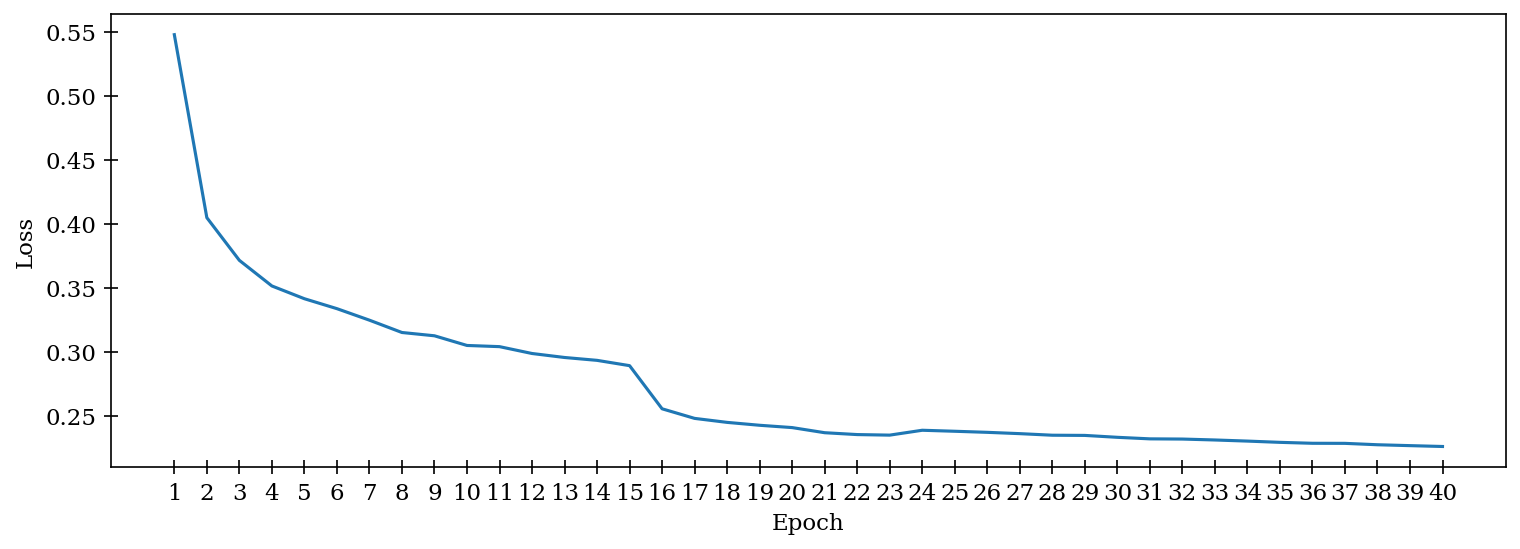

In [18]:
# Plot training loss
num_epochs = 40
epoch_step = 1

loss_lst = []

for epoch in range(epoch_step, num_epochs + epoch_step, epoch_step):
    checkpoint = torch.load(f'../src/obb/model/checkpoints/epoch_{epoch}.pt', map_location=torch.device('cpu'))
    loss_lst.append(checkpoint['loss'])
    print(f"Epoch {epoch}: {checkpoint['loss']:.6f}")
    del checkpoint

fig = plt.figure(figsize=(12, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(epoch_step, num_epochs + epoch_step, epoch_step), loss_lst)
ax.set_xticks(range(1, num_epochs + epoch_step, epoch_step))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epoch = 40  # Most recent epoch

# Load trained weights to detector
checkpoint = torch.load(f'../src/obb/model/checkpoints/epoch_{epoch}.pt', map_location=torch.device('cpu'))
model = DetectionModel().to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

# Create loss instance
rep_points_loss = OrientedRepPointsLoss(strides=model.feature_map_strides)

Using cache found in C:\Users\matan/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-4-24 torch 1.10.0+cpu CPU

Fusing layers... 
Model summary: 290 layers, 21640929 parameters, 0 gradients
Adding AutoShape... 


torch.Size([81, 8])
torch.Size([81, 2]) torch.Size([81, 2, 2])
torch.Size([138, 8])
torch.Size([138, 2]) torch.Size([138, 2, 2])
torch.Size([136, 8])
torch.Size([136, 2]) torch.Size([136, 2, 2])
torch.Size([0])
torch.Size([0, 2]) torch.Size([0, 2, 2])


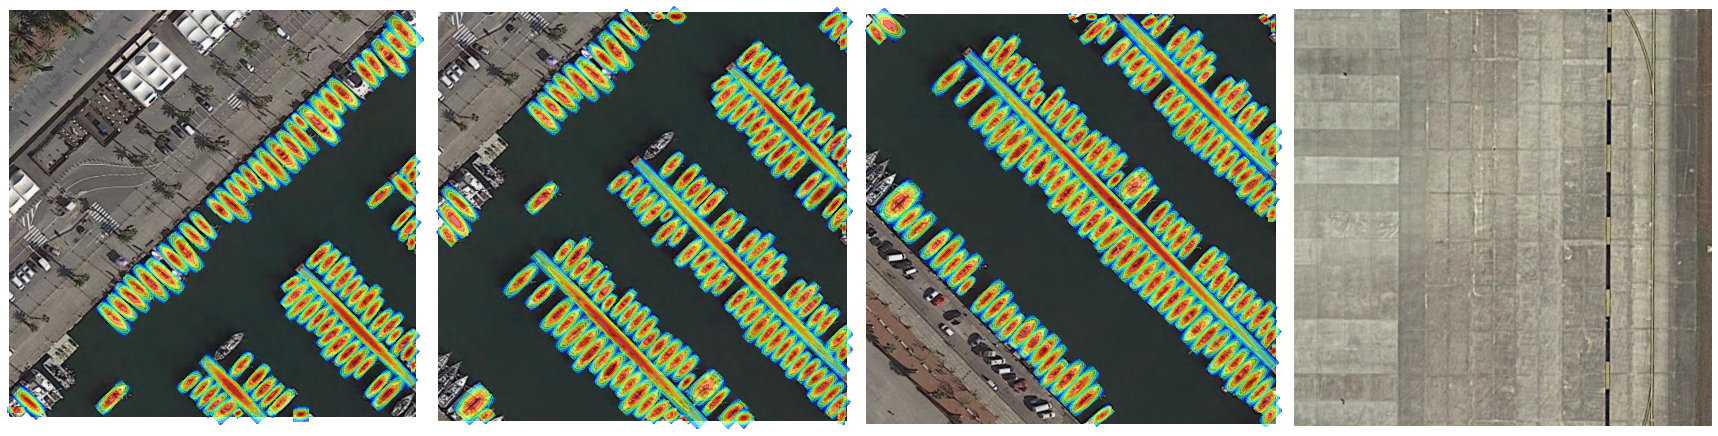

In [44]:
# Load sample dataset
train_dataset = Dataset(path='../assets/DOTA_sample_data/split')
train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

fig = plt.figure(figsize=(24, 8))
num_imgs = len(train_data_loader)
for idx, (img, obb, object_class) in enumerate(train_data_loader):
    img = img.to(device)
    mu, S = rep_points_to_gaussian(obb.reshape(-1, 4, 2))
    obb = obb.squeeze(dim=0)
    print(obb.shape)
    print(mu.shape, S.shape)
    ax = fig.add_subplot(1, len(train_data_loader), idx + 1)
    ax.imshow(img.squeeze().permute(1, 2, 0).numpy())

    obb_xywha = torch.zeros(obb.shape[0], 6)
    for i, bbox in enumerate(obb):
        obb_xywha[i] = torch.Tensor(xyxy_to_xywha(bbox.reshape(-1, 2)))

        x0, y0, w, h, c, s = obb_xywha[i]
        x, y = np.arange(-0.5*w, 0.5*w, 0.1), np.arange(-0.5*h, 0.5*h, 0.1)
        xx, yy = np.meshgrid(x, y)
        xx, yy = c * xx - s * yy, s * xx + c * yy
        xx += x0
        yy += y0
        pos = np.dstack((xx, yy))
        rv1 = multivariate_normal(mean=mu[i], cov=S[i])
        rv2 = multivariate_normal(mean=mu[i], cov=S[i])

        ax.contourf(xx, yy, rv1.pdf(pos), alpha=0.5, cmap='jet')

    ax.set_axis_off()

plt.tight_layout()

Feeding image #1...
Loss: 1.1901
Classification: 0.0128
Localization init: 1.0347
Spatial constraint init: 0.0000
Regression refine: 0.6599
Class precisions:
['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '1.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
Class recalls:
['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '1.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
Feeding image #2...
Loss: 1.5465
Classification: 0.0000
Localization init: 1.0567
Spatial constraint init: 0.0000
Regression refine: 1.0182
Class precisions:
['1.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
Class recalls:
['1.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
Feeding image #3...
Loss: 1.4190
Classification: 0

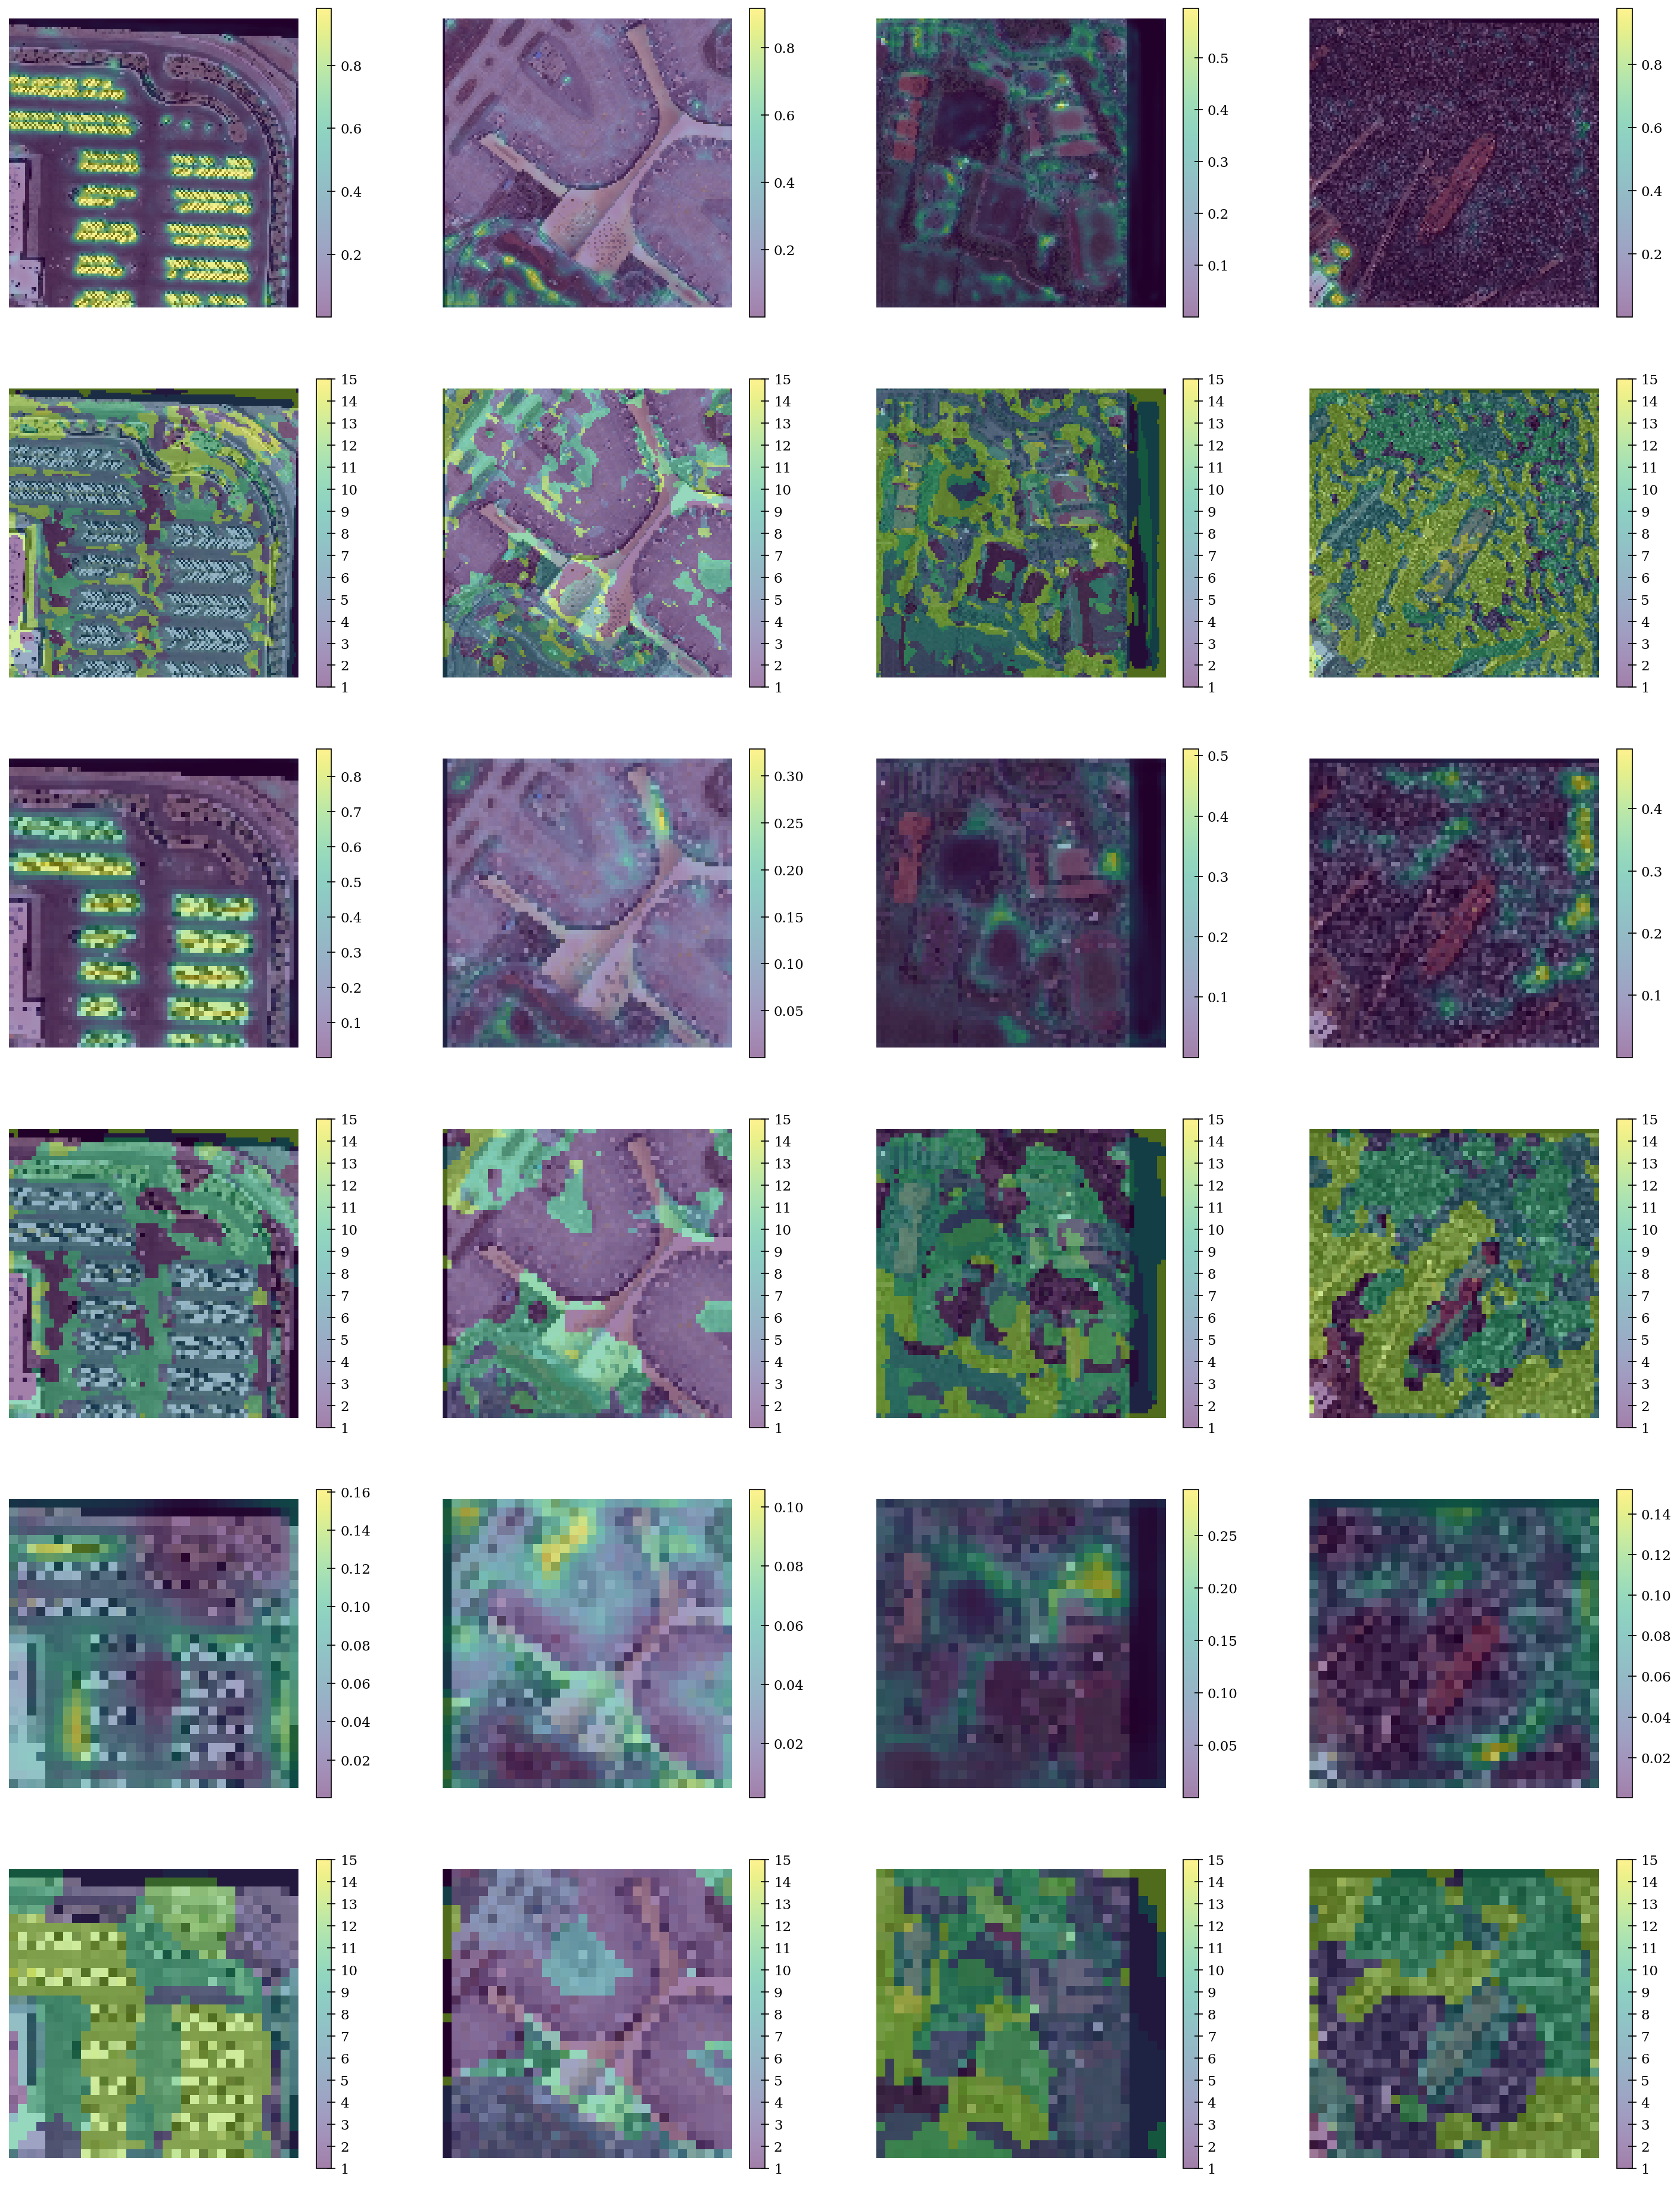

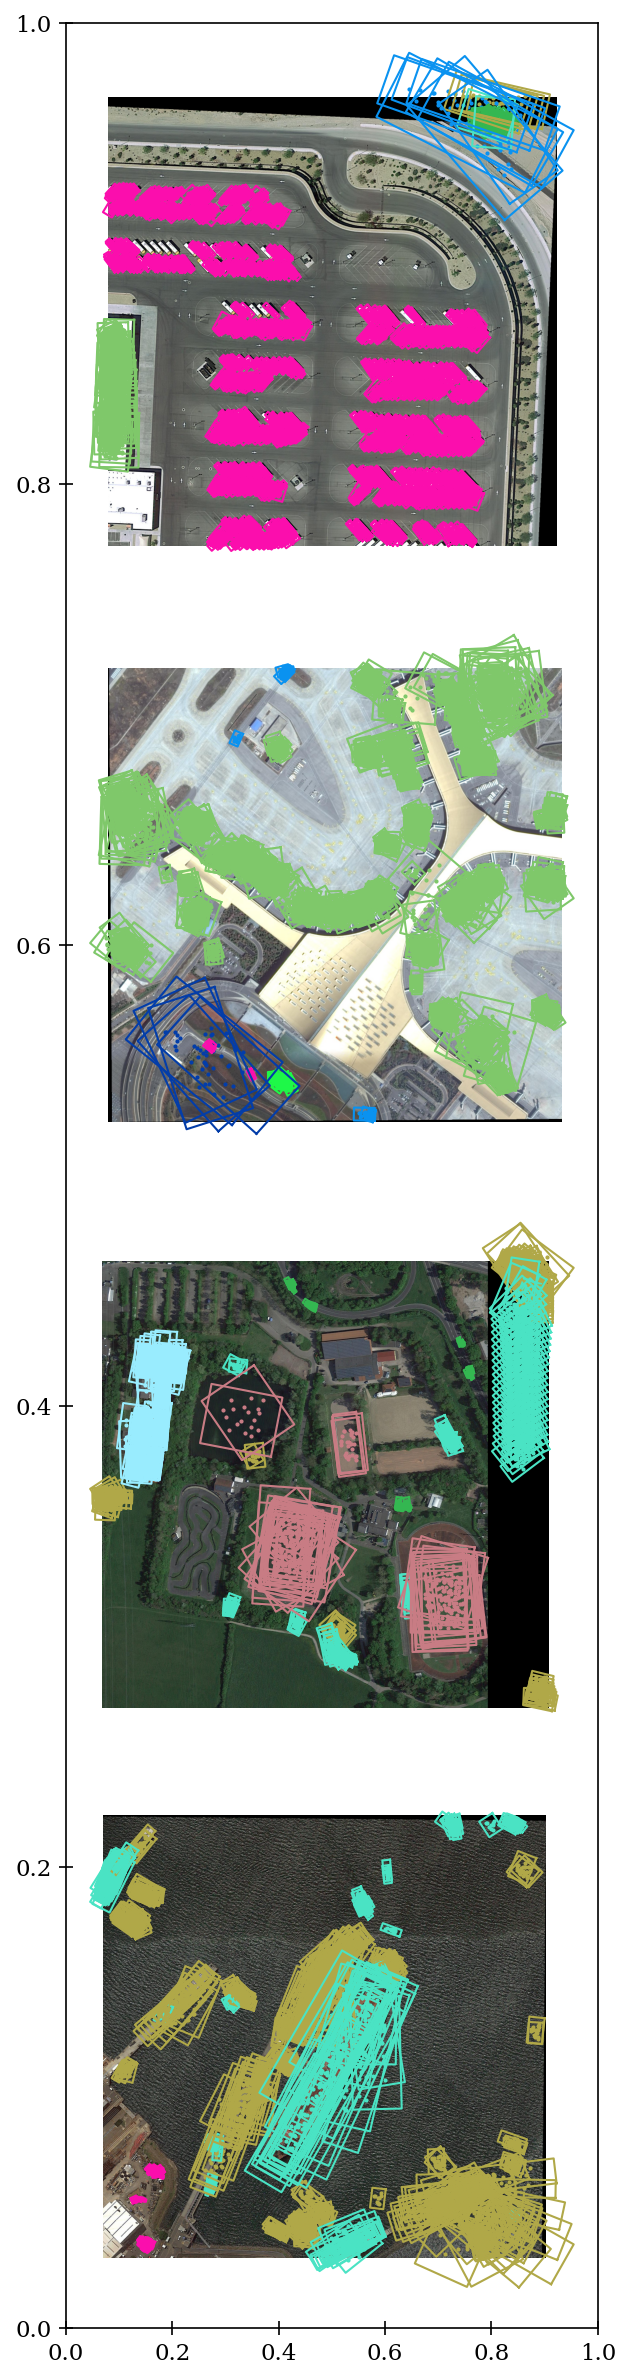

In [202]:
colors = []

for i in range(1, 16):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

# Classification thresholds
threshold_dict = {
    'P3': 0.9,
    'P4': 0.9,
    'P5': 0.9
}

# Feature map strides
stride_dict = {'P3': 8, 'P4': 16, 'P5': 32}

# Get feature maps
fig = plt.figure(figsize=(24, 32), dpi=150)
fig1 = plt.figure(figsize=(4, 16), dpi=150)
for idx, (img, obb, object_class) in enumerate(train_data_loader):
    print(f'Feeding image #{idx+1}...')

    img = img.to(device)
    obb = obb.squeeze(dim=0)
    object_class = object_class.squeeze(dim=0)

    rep_points_init, rep_points_refine, classification = model(img)

    loss, loss_dict = rep_points_loss.get_loss(rep_points_init, rep_points_refine, classification, obb, object_class)

    print(f"Loss: {float(loss):.4f}")
    print(f"Classification: {float(loss_dict['classification']):.4f}")
    print(f"Localization init: {float(loss_dict['localization_init']):.4f}")
    print(f"Spatial constraint init: {float(loss_dict['spatial_constraint_init']):.4f}")
    print(f"Regression refine: {float(loss_dict['regression_refine']):.4f}")
    print('Class precisions:')
    print([f'{float(prc):.4f}' for prc in loss_dict['precision']])
    print('Class recalls:')
    print([f'{float(rcl):.4f}' for rcl in loss_dict['recall']])

    num_lvls = len(classification.keys())
    for lvl_idx, lvl in enumerate(classification.keys()):
        stride = stride_dict[lvl]  # Stride of current level

        # Get classification
        cls = torch.softmax(classification[lvl][0], dim=0)
        cls_hard = torch.argmax(classification[lvl][0], dim=0) + 1

        # Classification (probability)
        ax = fig.add_subplot(2 * num_lvls, len(train_data_loader), 2 * num_imgs * lvl_idx + idx + 1)
        ax.imshow(img.squeeze().permute(1, 2, 0)[::stride, ::stride].numpy())
        class_map = ax.imshow(cls[5].detach().numpy(), alpha=0.5)
        ax.set_axis_off()
        plt.colorbar(class_map, ax=ax)

        # Classification (hard)
        ax = fig.add_subplot(2 * num_lvls, len(train_data_loader), 2 * num_imgs * lvl_idx + idx + 1 + num_imgs)
        ax.imshow(img.squeeze().permute(1, 2, 0)[::stride, ::stride].numpy())
        class_map = ax.imshow(cls_hard.detach().numpy(), vmin=1, vmax=15, alpha=0.5)
        ax.set_axis_off()
        plt.colorbar(class_map, ax=ax, ticks=range(1, 16))

    # Localization
    ax = fig1.add_subplot(len(train_data_loader), 1, idx + 1)
    ax.imshow(img.squeeze().permute(1, 2, 0).numpy())
    for lvl_idx, lvl in enumerate(classification.keys()):
        stride = stride_dict[lvl]  # Stride of current level

        cls, pts = torch.softmax(classification[lvl][0], dim=0), rep_points_refine[lvl][0]
        cls_hard = torch.argmax(cls, dim=0).to(int) + 1
        for i in range(0, pts.shape[1], 1):
            for j in range(0, pts.shape[2], 1):
                pt_set = pts[:, i, j].reshape(-1, 2)
                if cls[cls_hard[i, j] - 1, i, j] > threshold_dict[lvl]:
                    mu, S = rep_points_to_gaussian(pt_set.unsqueeze(dim=0))
                    rect_xywha = gaussian_to_xywha(mu, S)
                    rect = xywha_to_xyxy(rect_xywha)[0].reshape(-1, 2)
                    ax.scatter(pt_set[:, 0].detach().numpy(), pt_set[:, 1].detach().numpy(), s=1, color=colors[cls_hard[i, j] - 1])
                    ax.plot(torch.cat((rect[:, 0], rect[0, 0].reshape(1))).detach().numpy(),
                            torch.cat((rect[:, 1], rect[0, 1].reshape(1))).detach().numpy(),
                            linewidth=1, color=colors[cls_hard[i, j] - 1])
                    # ax.scatter([j * stride], [i * stride], s=4)

    ax.set_axis_off()

plt.tight_layout()

Feeding image #1...
Flattening image #1...
NMSing image #1...
66
57
49
45
38
31
25
19
14
8
2
784
760
737
729
720
700
682
665
642
624
615
592
590
586
572
538
526
516
510
485
474
455
437
429
421
409
398
393
362
340
328
313
303
291
267
241
238
224
215
208
192
175
167
157
146
140
119
109
107
104
95
73
72
65
55
53
50
47
38
35
31
29
15
13
10
8
6
4
3
2
1
4
Feeding image #2...
Flattening image #2...
NMSing image #2...
23
14
8
5
1097
1077
1060
1041
1032
1014
1003
987
969
960
944
927
907
900
887
865
860
842
834
831
816
795
786
779
758
737
720
706
701
691
671
667
663
658
636
627
605
598
586
581
564
555
546
534
527
514
504
494
486
480
466
448
441
432
426
418
398
385
377
366
348
329
316
294
279
276
274
272
263
251
245
232
223
220
219
215
210
196
191
183
178
172
168
152
151
145
142
132
124
113
111
104
89
82
72
64
60
55
53
50
47
45
41
37
33
27
25
22
13
12
6
5
4
3
1
1
Feeding image #3...
Flattening image #3...
NMSing image #3...
43
35
31
25
18
12
7
3
2
1
1088
1068
1048
1037
1019
1000
983
966
959
941
9

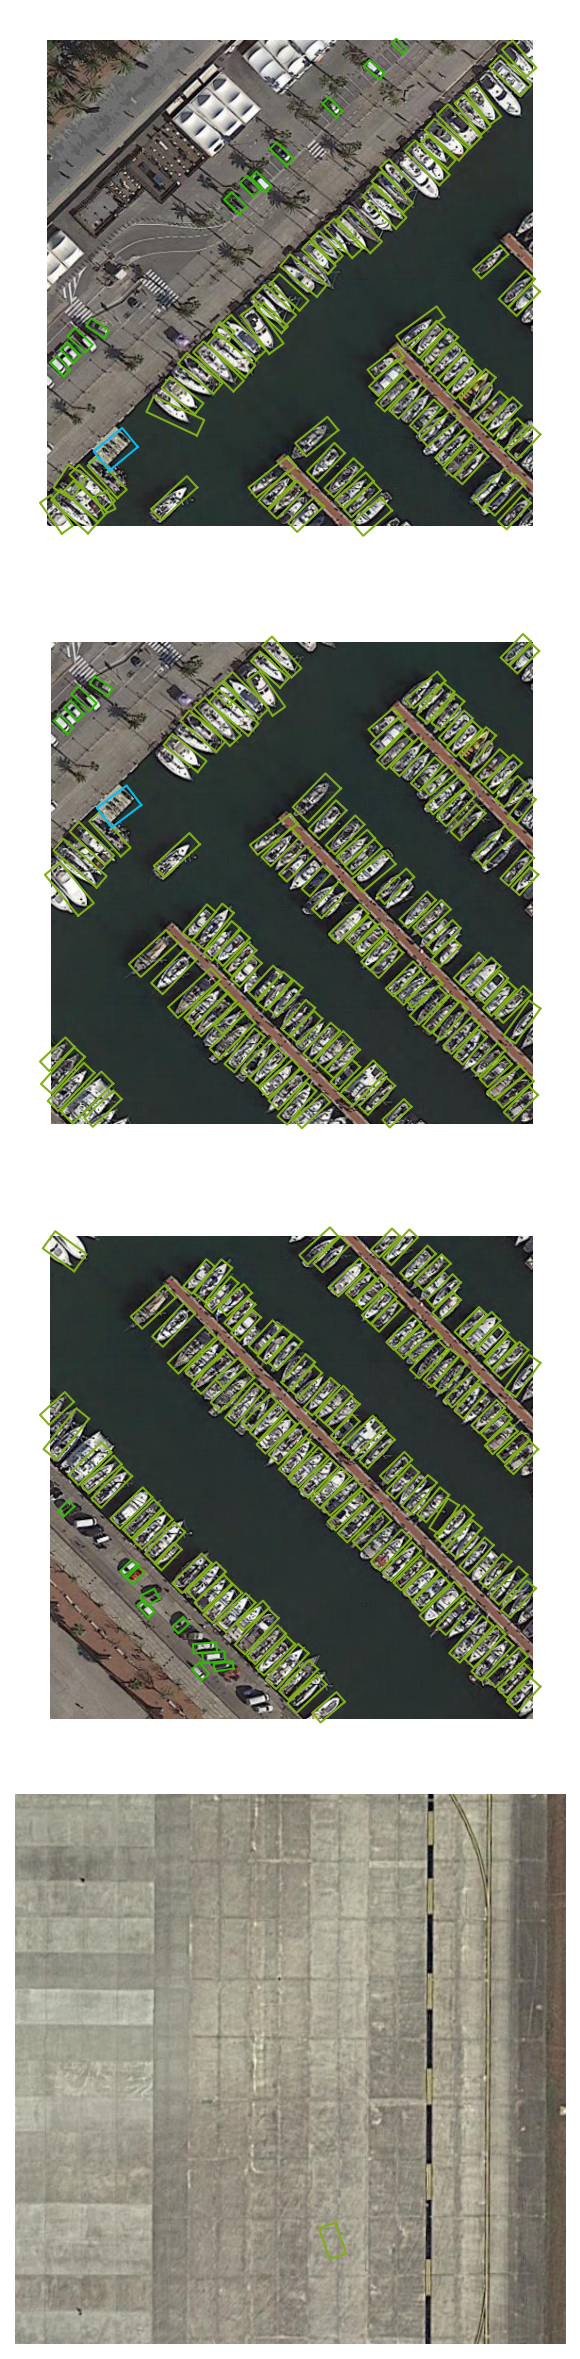

In [51]:
colors = []

for i in range(1, 16):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

fig = plt.figure(figsize=(4, 16), dpi=150)
for idx, (img, obb, object_class) in enumerate(train_data_loader):

    img = img.to(device)
    obb = obb.squeeze(dim=0)
    object_class = object_class.squeeze(dim=0)

    # Get feature maps
    print(f'Feeding image #{idx+1}...')
    rep_points_init, rep_points_refine, classification = model(img)

    # Flatten feature maps
    print(f'Flattening image #{idx+1}...')
    classification_flattened, rep_points_flattened = flatten_head_output(classification, rep_points_refine)

    # Perform nms
    print(f'NMSing image #{idx+1}...')
    classification_nms, rep_points_nms = nms_kl(classification_flattened, rep_points_flattened, cls_thr=0.93, nms_thr=20)

    # Visualize results
    ax = fig.add_subplot(len(train_data_loader), 1, idx + 1)
    ax.imshow(img.squeeze().permute(1, 2, 0).numpy())
    for classification, rep_points in zip(classification_nms, rep_points_nms):
        cls, pts = torch.softmax(classification, dim=0), rep_points.reshape(-1, 2)
        cls_hard = torch.argmax(cls).to(int) + 1
        mu, S = rep_points_to_gaussian(pts.unsqueeze(dim=0))
        rect_xywha = gaussian_to_xywha(mu, S)
        rect = xywha_to_xyxy(rect_xywha)[0].reshape(-1, 2)
        # ax.scatter(pts[:, 0].detach().numpy(), pts[:, 1].detach().numpy(), s=1, color=colors[cls_hard - 1])
        ax.plot(torch.cat((rect[:, 0], rect[0, 0].reshape(1))).detach().numpy(),
                torch.cat((rect[:, 1], rect[0, 1].reshape(1))).detach().numpy(),
                linewidth=1, color=colors[cls_hard - 1])

    ax.set_axis_off()

plt.tight_layout()